In [ ]:
import pandas as pd
import numpy as np
import torch

from sklearn.preprocessing import normalize
from transformers import AutoTokenizer, AutoModelForSequenceClassification,AutoModel
from pythainlp.tokenize import word_tokenize

import re
import unicodedata
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, AutoModel
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import coalesce



part Import 

pip install --quiet transformers
pip install torch
pip install pandas
pip install pythainlp

In [36]:
# โหลดไฟล์ CSV (กรณีชื่อคอลัมน์ 'label')
df = pd.read_csv('news_dataset_truefakenews.csv')
# ถ้าชื่อคอลัมน์สะกดผิด
df = df.rename(columns={'lable':'label', 'autor':'author'})

In [37]:
# กำหนด mapping dictionary
label_map = {
    'ข่าวจริง': 'true',
    'คลังความรู้': 'true',
    'ข่าวปลอม': 'fake',
    'อาชญากรออนไลน์': 'fake',
    'ข่าวบิดเบือน': 'fake',
    'ข่าวอื่นๆ': None  # ะลบออกเลย
}

In [38]:
# 2) ทำความสะอาด label ลบอิโมจิ และแมปค่า 
ZW = ''.join(['\u200B','\u200C','\u200D','\uFEFF'])

def normalize_thai(s):
    if pd.isna(s):
        return None
    s = str(s).replace('\u00A0',' ').translate({ord(ch):None for ch in ZW})
    s = unicodedata.normalize('NFC', s)
    s = re.sub(r'\s+', ' ', s).strip()
    s = re.sub(r'([\u0E31\u0E34-\u0E3A\u0E47-\u0E4E])\1+', r'\1', s)
    return s

df['label'] = df['label'].apply(normalize_thai)

# เลือกฉลากมาตรฐาน
CANON = {'ข่าวจริง':'ข่าวจริง', 'ข่าวปลอม':'ข่าวปลอม'}

# map เคสเพี้ยน
ALIASES = {
    'ข่าวจริิง':'ข่าวจริง',
    'ข่่าวจริง':'ข่าวจริง',
    'ข่่าวบิดเบือน':'ข่าวบิดเบือน',
}
df['label'] = df['label'].replace(ALIASES)

# กรองฉลากที่ต้องการและ drop row ที่ไม่มี title/content
df = df[df['label'].isin(CANON.keys())].dropna(subset=['title','content']).reset_index(drop=True)

In [39]:
# สร้างคอลัมน์ใหม่ 'label_binary' เป็น binary label จาก mapping
#df['label_binary'] = df['label'].map(label_map)

# ลบแถวที่เป็น None (ข่าวอื่นๆ)
#df = df.dropna(subset=['label_binary'])

# ถ้าต้องการ save เป็น CSV ใหม่
#df.to_csv('news_dataset_truefakenews.csv', index=False)

# ดูผลลัพธ์
print(df.head())

                  date                                         link  \
0  23/07/2568 09:00:20  https://www.antifakenewscenter.com/?p=74581   
1  23/07/2568 08:00:51  https://www.antifakenewscenter.com/?p=74577   
2  23/07/2568 07:00:51  https://www.antifakenewscenter.com/?p=74573   
3  23/07/2568 06:30:23  https://www.antifakenewscenter.com/?p=74569   
4  23/07/2568 03:30:03  https://www.antifakenewscenter.com/?p=74561   

                                               title  \
0  OR ชวนร่วมเป็นเจ้าของกิจการ ลงทุนหุ้น IPO เริ่...   
1  กระทรวงยุติธรรม เปิดเพจเฟซบุ๊กชื่อ Technology ...   
2  หุ้น OKJ เปิดเทรดวันแรก ราคาเปิดพอร์ตเริ่มต้น ...   
3  กรุงไทย เปิดให้จองสิทธิ์ยืมเงิน 100,000 บาท ลง...   
4            ก.ล.ต. เปิดเว็บไซต์ให้ผู้ลงทุนสะสมคะแนน   

                                             content  \
0  จากที่มีการโฆษณาระบุเปิดให้ลงทุนหุ้น IPO ข้างต...   
1  ระวังเพจปลอมแอบอ้างหน่วยงาน เพจเฟซบุ๊กชื่อ Tec...   
2  เช็กข้อมูลให้ชัวร์ก่อนติดตาม เพจ “OH KAD” เป็น...   
3  การปล่อยส

In [40]:
# 3) ตัดคำ (ไม่เก็บช่องว่าง)
def thai_token_list(text):
    if pd.isna(text):
        return []
    return word_tokenize(text, engine='newmm', keep_whitespace=False)

df['title_tokens'] = df['title'].apply(thai_token_list)
df['content_tokens'] = df['content'].apply(thai_token_list)

In [41]:
# 4) โหลดโมเดลภาษาไทย + จัด device
model_name = "airesearch/wangchanberta-base-att-spm-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

model = AutoModel.from_pretrained(model_name) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = model.to(device).eval()


Num True News: 233
Num Fake News: 585


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3586 (\N{THAI CHARACTER KHO KHAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3656 (\N{THAI CHARACTER MAI EK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifake

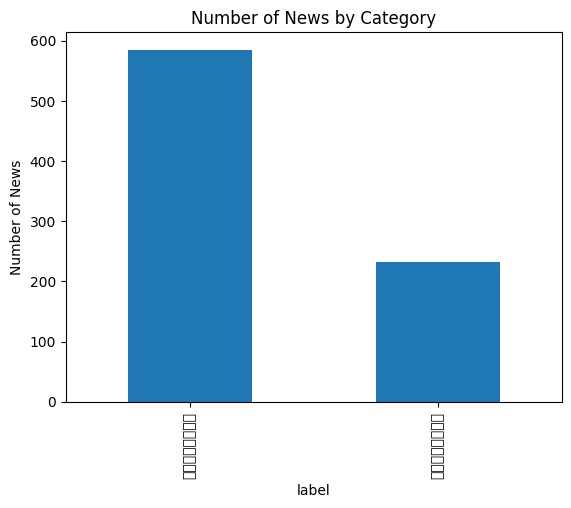

In [42]:
num_true = (df['label_binary'] == 'true').sum() 
num_fake = (df['label_binary'] == 'fake').sum() 
print(f"Num True News: {num_true}\nNum Fake News: {num_fake}")


#กราฟ
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar') 
plt.title('Number of News by Category') 
plt.ylabel('Number of News') 
plt.show()

In [43]:
# Show sample of tokenized data
print("Sample of tokenized titles:")
print(df[['title', 'title_tokens']].head())
print("\nSample of tokenized content:")
print(df[['content', 'content_tokens']].head())

# Print token statistics
print("\nToken statistics:")
print(f"Average tokens in titles: {df['title_tokens'].str.len().mean():.2f}")
print(f"Average tokens in content: {df['content_tokens'].str.len().mean():.2f}")

Sample of tokenized titles:
                                               title  \
0  OR ชวนร่วมเป็นเจ้าของกิจการ ลงทุนหุ้น IPO เริ่...   
1  กระทรวงยุติธรรม เปิดเพจเฟซบุ๊กชื่อ Technology ...   
2  หุ้น OKJ เปิดเทรดวันแรก ราคาเปิดพอร์ตเริ่มต้น ...   
3  กรุงไทย เปิดให้จองสิทธิ์ยืมเงิน 100,000 บาท ลง...   
4            ก.ล.ต. เปิดเว็บไซต์ให้ผู้ลงทุนสะสมคะแนน   

                                        title_tokens  
0  [OR, ชวน, ร่วม, เป็น, เจ้าของกิจการ, ลงทุน, หุ...  
1  [กระทรวงยุติธรรม, เปิด, เพจ, เฟซบุ๊ก, ชื่อ, Te...  
2  [หุ้น, OKJ, เปิด, เทรด, วัน, แรก, ราคา, เปิด, ...  
3  [กรุงไทย, เปิด, ให้, จอง, สิทธิ์, ยืม, เงิน, 1...  
4  [ก.ล.ต., เปิด, เว็บไซต์, ให้, ผู้ลงทุน, สะสม, ...  

Sample of tokenized content:
                                             content  \
0  จากที่มีการโฆษณาระบุเปิดให้ลงทุนหุ้น IPO ข้างต...   
1  ระวังเพจปลอมแอบอ้างหน่วยงาน เพจเฟซบุ๊กชื่อ Tec...   
2  เช็กข้อมูลให้ชัวร์ก่อนติดตาม เพจ “OH KAD” เป็น...   
3  การปล่อยสินเชื่อ บนบัญชี TikTok ชื่อ ktb.thai ..

In [45]:

# 5) ฟังก์ชัน embedding
@torch.no_grad()
def get_bert_embedding_from_tokens(tokens, max_length=128, use_mean_pool=False):
    text = ' '.join(tokens)
    inputs = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    ).to(device)
    outputs = model(**inputs)  # last_hidden_state: [1, L, H]
    if use_mean_pool:
        attn = inputs['attention_mask'].unsqueeze(-1)  # [1, L, 1]
        summed = (outputs.last_hidden_state * attn).sum(dim=1)
        denom = attn.sum(dim=1).clamp(min=1)
        emb = (summed / denom).squeeze(0).cpu().numpy()
    else:
        emb = outputs.last_hidden_state[:, 0, :].squeeze(0).cpu().numpy()  # CLS
    return emb


หน้าตาเป็นไง

In [46]:
# 6) สร้าง embedding
use_content = True
title_emb = np.vstack([get_bert_embedding_from_tokens(toks) for toks in df['title_tokens']])
if use_content:
    content_emb = np.vstack([get_bert_embedding_from_tokens(toks) for toks in df['content_tokens']])
    x_np = np.concatenate([title_emb, content_emb], axis=1)
else:
    x_np = title_emb
x_np = normalize(x_np, norm='l2', axis=1)


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [47]:
import pandas as pd
pd.DataFrame(x_np).head()

print(x_np.shape)   # ดูขนาด เช่น (จำนวนเอกสาร, ขนาดเวกเตอร์)
print(x_np[0])      # ดู embedding ของตัวอย่างแรก


(818, 1536)
[ 0.02091332 -0.03751069  0.0273895  ... -0.01763099  0.01865094
 -0.01614046]


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3604 (\N{THAI CHARACTER DO DEK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3657 (\N{THAI CHARACTER MAI THO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3609 (\N{THAI CHARACTER NO NU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


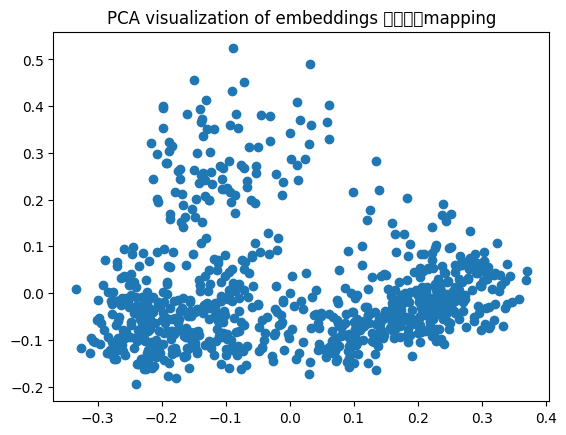

In [48]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
x_2d = pca.fit_transform(x_np)

plt.scatter(x_2d[:,0], x_2d[:,1])
plt.title("PCA visualization of embeddings ด้านmapping")
plt.show()


c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3604 (\N{THAI CHARACTER DO DEK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3657 (\N{THAI CHARACTER MAI THO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3609 (\N{THAI CHARACTER NO NU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenew

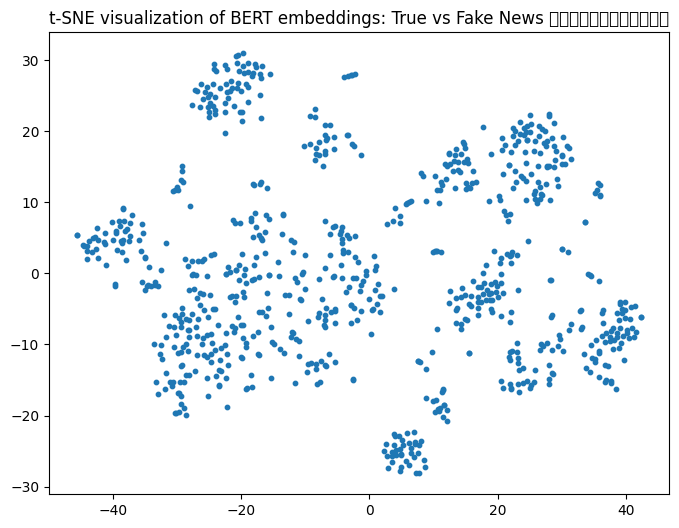

In [49]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
x_2d = tsne.fit_transform(x_np)

plt.figure(figsize=(8,6))
plt.scatter(x_2d[:,0], x_2d[:,1], s=10)
plt.title("t-SNE visualization of BERT embeddings: True vs Fake News ด้านความหมาย")
plt.show()


เสร็จ embedding //ทำไมจุดเป็นแบบนี้

In [50]:
# 7) แปลง labels -> ตัวเลข
classes = sorted(df['label'].unique())
label2id = {c:i for i,c in enumerate(classes)}
y_np = df['label'].map(label2id).values
print("Classes:", label2id)

Classes: {'ข่าวจริง': 0, 'ข่าวปลอม': 1}


In [51]:
# 8) สร้าง kNN-graph (cosine similarity)
N = x_np.shape[0]
k = min(8, max(3, int(np.round(np.log2(max(N, 2))))))  # สูตรง่ายสำหรับ N < 1000

# สร้างเพื่อนบ้านใกล้สุดแบบ cosine distance
nbrs = NearestNeighbors(n_neighbors=k+1, metric='cosine').fit(x_np)
dist, idx = nbrs.kneighbors(x_np)

# edge direction และ weight (similarity = 1 - distance)
src = np.repeat(np.arange(N), k)
dst = idx[:, 1:].reshape(-1)
w = 1.0 - dist[:, 1:].reshape(-1)

# สร้าง undirected edges
edge_index_np = np.vstack([src, dst])
edge_index_np_rev = edge_index_np[::-1, :]
edge_index_np = np.concatenate([edge_index_np, edge_index_np_rev], axis=1)
edge_weight_np = np.concatenate([w, w], axis=0)

# แปลงเป็น torch tensor
edge_index = torch.tensor(edge_index_np, dtype=torch.long)
edge_weight = torch.tensor(edge_weight_np, dtype=torch.float)

# รวม edge ซ้ำ (ใช้ได้กับ PyG รุ่นใหม่)
edge_index, edge_weight = coalesce(edge_index, edge_weight, reduce='mean')


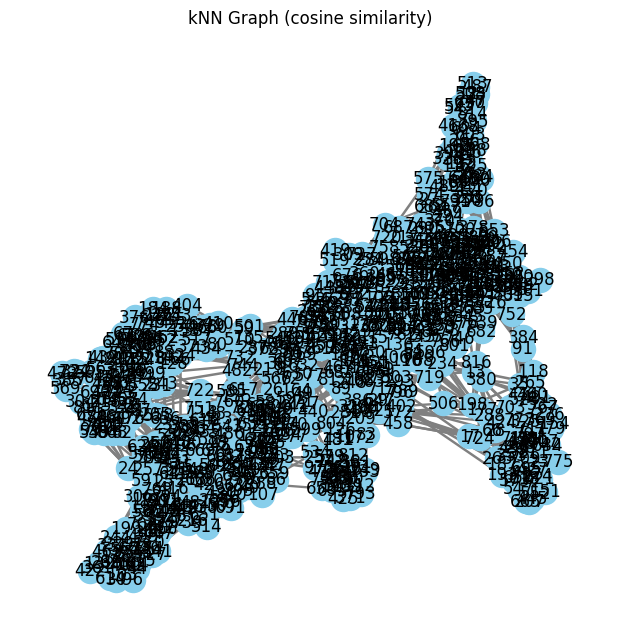

In [52]:
import networkx as nx
import matplotlib.pyplot as plt

# สร้างกราฟจาก edge_index_np
G = nx.Graph()
edges = list(zip(edge_index_np[0], edge_index_np[1]))
G.add_edges_from(edges)

# ถ้าอยากใช้ weight เป็นความหนาของเส้น
weights = edge_weight_np

plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, seed=42)  # layout สวยงามอัตโนมัติ
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', width=weights * 2)
plt.title("kNN Graph (cosine similarity)")
plt.show()


In [53]:
# 9) สร้าง Data + split
x = torch.tensor(x_np, dtype=torch.float)
y = torch.tensor(y_np, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y)
data.edge_weight = edge_weight

# split 70/15/15 stratified
idx_all = np.arange(N)
idx_train, idx_test = train_test_split(idx_all, test_size=0.15, stratify=y_np, random_state=42)
idx_train, idx_val = train_test_split(idx_train, test_size=0.1765, stratify=y_np[idx_train], random_state=42)

train_mask = torch.zeros(N, dtype=torch.bool); train_mask[idx_train] = True
val_mask = torch.zeros(N, dtype=torch.bool); val_mask[idx_val] = True
test_mask = torch.zeros(N, dtype=torch.bool); test_mask[idx_test] = True
data.train_mask, data.val_mask, data.test_mask = train_mask, val_mask, test_mask


In [54]:
print(y_np)  # แสดงค่าทุกอัน
print(np.unique(y_np, return_counts=True))  

[1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0
 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 0 1
 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0
 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 1
 0 1 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1
 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 0 1 0
 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0
 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 1 1 1 1
 1 1 1 0 1 1 0 1 0 1 0 1 

In [82]:
# 10) สร้าง GCN model  4เลเยอร์
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNNet(torch.nn.Module):
    """
    Graph Convolutional Network (GCN) with 4 layers.
    Uses WangchanBERTa embeddings as node features (input_features).
    """
    def __init__(self, num_node_features, num_classes, hidden_channels=128, dropout_rate=0.5):
        super().__init__()
        
        # 1. Input Layer: Feature Size -> Hidden Size
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        
        # 2. Hidden Layer 2: Hidden Size -> Hidden Size
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        
        # 3. Hidden Layer 3: Hidden Size -> Hidden Size
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        
        # 4. Output Layer: Hidden Size -> Number of Classes
        self.conv4 = GCNConv(hidden_channels, num_classes)
        
        self.dropout_rate = dropout_rate

    def forward(self, data):
        # Unpack data
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        
        # Layer 1: GCN -> ReLU -> Dropout
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        
        # Layer 2: GCN -> ReLU -> Dropout
        x = self.conv2(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        
        # Layer 3: GCN -> ReLU -> Dropout
        x = self.conv3(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        
        # Layer 4: Output Layer (no ReLU/Dropout)
        x = self.conv4(x, edge_index, edge_weight)
        
        # F.log_softmax สำหรับใช้กับ F.cross_entropy
        return F.log_softmax(x, dim=1)

In [88]:
# แก้ไขบรรทัดเรียกใช้โมเดล โดยสมมติว่าคุณได้ใช้โค้ดที่ 10) ในการสร้างคลาส GCNNet แล้ว
# ต้องมั่นใจว่า GCNNet คือคลาสที่คุณกำหนดไว้ในโค้ด 10)
NUM_NODE_FEATURES = data.x.shape[1]
NUM_CLASSES = len(classes) # 2

model_gnn = GCNNet(
    num_node_features=NUM_NODE_FEATURES, 
    hidden_channels=128, 
    num_classes=NUM_CLASSES, 
    dropout_rate=0.5
).to(device_t)

# # คำนวณ class weight สำหรับแก้ imbalance (โค้ดนี้ถูกต้องแล้ว)
cls_w = compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=y_np)
cls_w = torch.tensor(cls_w, dtype=torch.float, device=device_t)

# ฟังก์ชันประเมินผล
def evaluate(logits, mask, data):
    # ดึงค่าออกจาก GPU ก่อนแปลงเป็น Numpy
    y_true = data.y[mask].cpu().numpy()
    y_pred = logits[mask].argmax(dim=1).cpu().numpy()
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro', zero_division=0) 
    return acc, f1m

# --- Hyperparameters ---
num_epochs = 500
LR_RATE = 1e-3 # ลด LR เป็น 1e-3 สำหรับ Deep GCN (4 layers)
WEIGHT_DECAY = 5e-4
PATIENCE_LIMIT = 30 
SCHEDULER_PATIENCE = 15

opt = torch.optim.Adam(model_gnn.parameters(), lr=LR_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.5, patience=SCHEDULER_PATIENCE)

best_val_f1, best_state = -1, None
patience_counter = 0

# --- Training Loop ---
for epoch in range(1, num_epochs + 1):
    model_gnn.train()
    opt.zero_grad()
    out = model_gnn(data)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask], weight=cls_w)
    loss.backward()
    opt.step()

    model_gnn.eval()
    with torch.no_grad():
        val_acc, val_f1 = evaluate(out, data.val_mask, data)

    # Early Stopping Logic
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch 
        best_state = {k: v.detach().cpu().clone() for k,v in model_gnn.state_dict().items()}
        patience_counter = 0 
    else:
        patience_counter += 1

    scheduler.step(val_f1)

    if epoch % 20 == 0 or epoch == num_epochs:
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | LR: {opt.param_groups[0]['lr']:.1e}")
    
    if patience_counter >= PATIENCE_LIMIT:
        print(f"*** Early stopping at epoch {epoch}. Best F1: {best_val_f1:.4f} found at epoch {best_epoch}. ***")
        break

# --- Final Evaluation ---
model_gnn.load_state_dict(best_state)
model_gnn.eval()
with torch.no_grad():
    final_out = model_gnn(data)
    test_acc, test_f1 = evaluate(final_out, data.test_mask, data)
    print("-" * 50)
    print(f"Training Complete. Best val F1: {best_val_f1:.4f} found at epoch {best_epoch}")
    print(f"Test Set Results: Accuracy: {test_acc:.4f}, F1-Macro: {test_f1:.4f}")

Epoch 020 | Loss: 0.4256 | Val Acc: 0.8537 | Val F1: 0.8354 | LR: 1.0e-03
Epoch 040 | Loss: 0.3532 | Val Acc: 0.8699 | Val F1: 0.8477 | LR: 1.0e-03
Epoch 060 | Loss: 0.3314 | Val Acc: 0.9024 | Val F1: 0.8858 | LR: 5.0e-04
Epoch 080 | Loss: 0.3303 | Val Acc: 0.8943 | Val F1: 0.8734 | LR: 2.5e-04
*** Early stopping at epoch 89. Best F1: 0.9048 found at epoch 59. ***
--------------------------------------------------
Training Complete. Best val F1: 0.9048 found at epoch 59
Test Set Results: Accuracy: 0.8780, F1-Macro: 0.8561


In [89]:
# load best model
if best_state is not None:
    model_gnn.load_state_dict({k: v.to(device_t) for k,v in best_state.items()})

In [91]:
# ------------------- รับ input จากผู้ใช้ -------------------
title = input("กรอกหัวข้อข่าว (ถ้าไม่มี ให้กด Enter):\n")
content = input("กรอกเนื้อหาข่าว (หรือคัดลอกบางส่วน):\n")

# เช็คว่า:
if not title and not content:
    print("กรุณาใส่ title หรือเนื้อหาข่าว อย่างน้อย 1 อย่าง")
else:
    result = predict_news(
        title=title,
        content=content,
        tokenizer=tokenizer,
        model_bert=model,
        model_gnn=model_gnn,
        df=df, x_np=x_np, label2id=label2id, device=device_t, topn=8
    )
    print("\nผลการตรวจสอบข่าว:")
    print(f">>> ข่าวนี้น่าจะเป็น :  {result['label']}   (ความมั่นใจ = {result['probability']:.3f})")
    print("รายละเอียด probability (แต่ละ class):จริง ซ้าย/ปลอม ขวา", result['proba_all'])

c:\Users\tt_pe\Documents\GitHub\Project_Thaifakenews\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `CamembertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



ผลการตรวจสอบข่าว:
>>> ข่าวนี้น่าจะเป็น :  ข่าวจริง   (ความมั่นใจ = 0.954)
รายละเอียด probability (แต่ละ class):จริง ซ้าย/ปลอม ขวา [0.9537253  0.04627471]


node_pos: 30, color_map: 30, G.nodes: 30


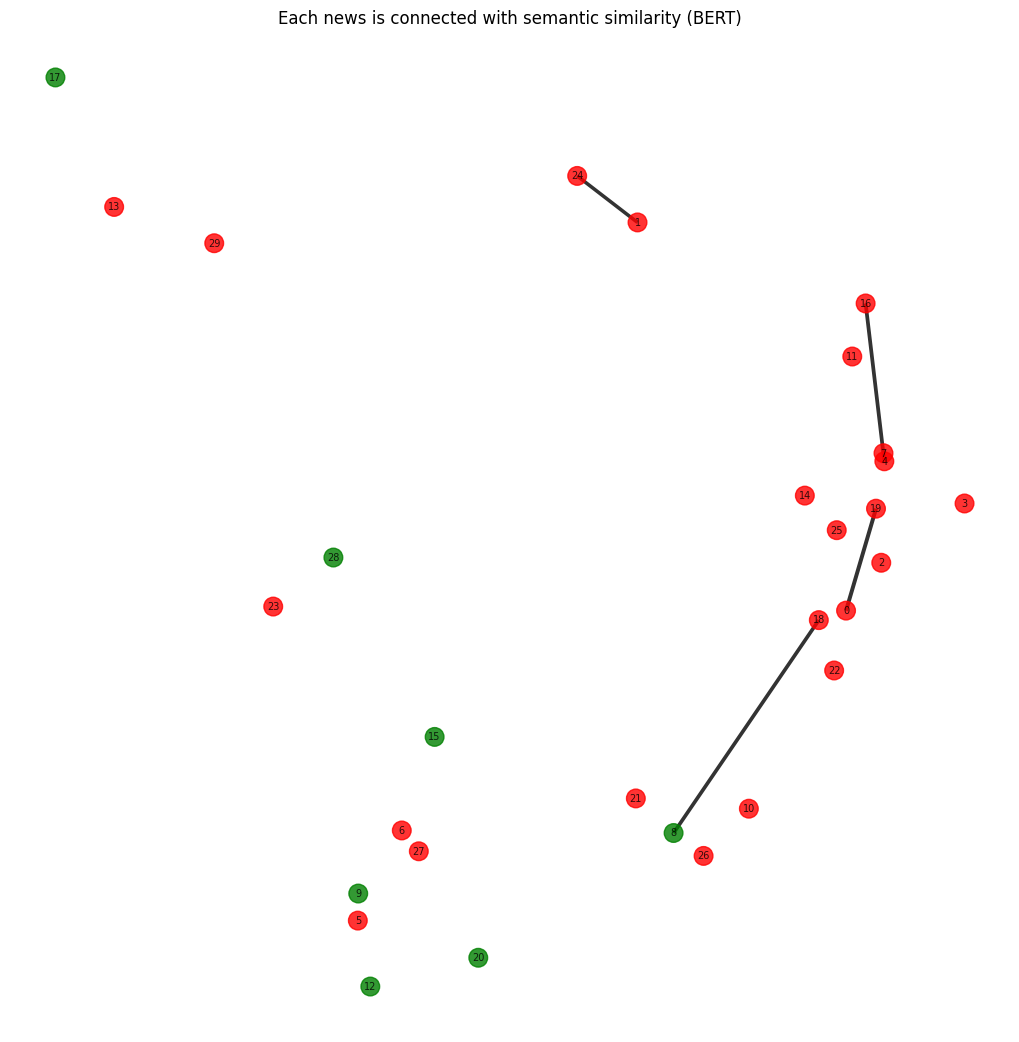

In [92]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# สมมติ plot 30 node แรก
subset_idx = np.arange(30)

subset_idx_set = set(subset_idx)
sub_edges = []
sub_weights = []
for i in range(edge_index_np.shape[1]):
    src, dst = edge_index_np[0, i], edge_index_np[1, i]
    if src in subset_idx_set and dst in subset_idx_set:
        sub_edges.append((src, dst))
        sub_weights.append(edge_weight_np[i])

G = nx.Graph()
G.add_nodes_from(subset_idx)  # เพื่อกัน node ที่ไม่มี edge หายไป
G.add_edges_from([(u, v, {"weight": float(w)}) for (u, v), w in zip(sub_edges, sub_weights)])

# PCA positions
node_emb = x_np[subset_idx]
pca = PCA(n_components=2)
node_pos_np = pca.fit_transform(node_emb)
node_pos = {idx: node_pos_np[i] for i, idx in enumerate(subset_idx)}

labels_now = df.iloc[subset_idx]['label'].values
color_map = ['red' if l=='ข่าวปลอม' else 'green' for l in labels_now]

print(f"node_pos: {len(node_pos)}, color_map: {len(color_map)}, G.nodes: {len(G.nodes())}")

plt.figure(figsize=(10, 10))
nx.draw(
    G,
    pos=node_pos,
    node_color=color_map,
    with_labels=True,
    node_size=180,
    alpha=0.8,
    width=[G[u][v]['weight']*3 for u,v in G.edges()],
    font_size=7
)
plt.title("Each news is connected with semantic similarity (BERT)")
plt.show()

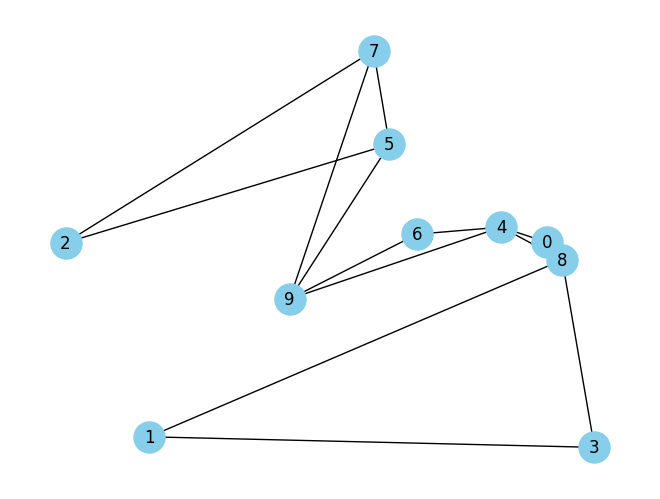

In [96]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import numpy as np

# random node features (สมมติแทน BERT embedding 2 มิติ)
X = np.random.rand(10, 2)

# สร้าง kNN graph
knn = NearestNeighbors(n_neighbors=3, metric='cosine').fit(X)
edges = knn.kneighbors_graph(X).toarray()

# วาดกราฟ
G = nx.Graph()
for i in range(len(X)):
    G.add_node(i, pos=X[i])
for i in range(len(X)):
    for j in range(len(X)):
        if edges[i, j] > 0 and i != j:
            G.add_edge(i, j)

pos = {i: X[i] for i in range(len(X))}
nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=500)
plt.show()


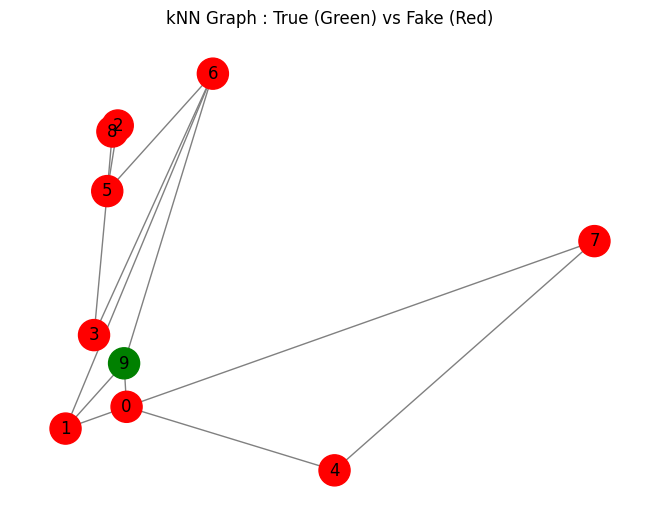

In [98]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import numpy as np

# random node features (แทน BERT embedding 2 มิติ)
X = np.random.rand(10, 2)

# label ของโหนด (0=ข่าวปลอม, 1=ข่าวจริง)
y = np.random.randint(0, 2, size=10)

# สร้าง kNN graph
knn = NearestNeighbors(n_neighbors=3, metric='cosine').fit(X)
edges = knn.kneighbors_graph(X).toarray()

# สร้างกราฟ
G = nx.Graph()
for i in range(len(X)):
    G.add_node(i, pos=X[i])
for i in range(len(X)):
    for j in range(len(X)):
        if edges[i, j] > 0 and i != j:
            G.add_edge(i, j)

# map label → สี
color_map = ["red" if label == 0 else "green" for label in y]

# วาดกราฟ
pos = {i: X[i] for i in range(len(X))}
nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=500, edge_color="gray")
plt.title("kNN Graph : True (Green) vs Fake (Red)")
plt.show()


In [99]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GCNNet(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hid_dim)
        self.conv2 = GCNConv(hid_dim, out_dim)
    def forward(self, data):
        x = self.conv1(data.x, data.edge_index)
        x = torch.relu(x)
        x = self.conv2(x, data.edge_index)
        return x

print(GCNNet(1536, 64, 2))


GCNNet(
  (conv1): GCNConv(1536, 64)
  (conv2): GCNConv(64, 2)
)


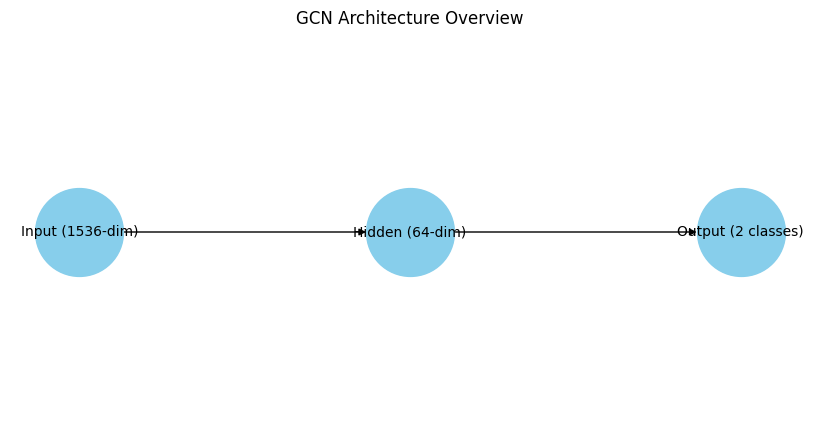

In [100]:
# ----- วาดโครงสร้าง GCN -----
G = nx.DiGraph()

# Layer nodes
layers = {
    "Input (1536-dim)": (0, 2),
    "Hidden (64-dim)": (1, 2),
    "Output (2 classes)": (2, 2)
}

# เพิ่มโหนด
for layer, pos in layers.items():
    G.add_node(layer, pos=pos)

# เพิ่ม edge
G.add_edge("Input (1536-dim)", "Hidden (64-dim)")
G.add_edge("Hidden (64-dim)", "Output (2 classes)")

# วาด
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(8,4))
nx.draw(G, pos, with_labels=True, node_size=4000, 
        node_color="skyblue", font_size=10, arrows=True)
plt.title("GCN Architecture Overview")
plt.show()


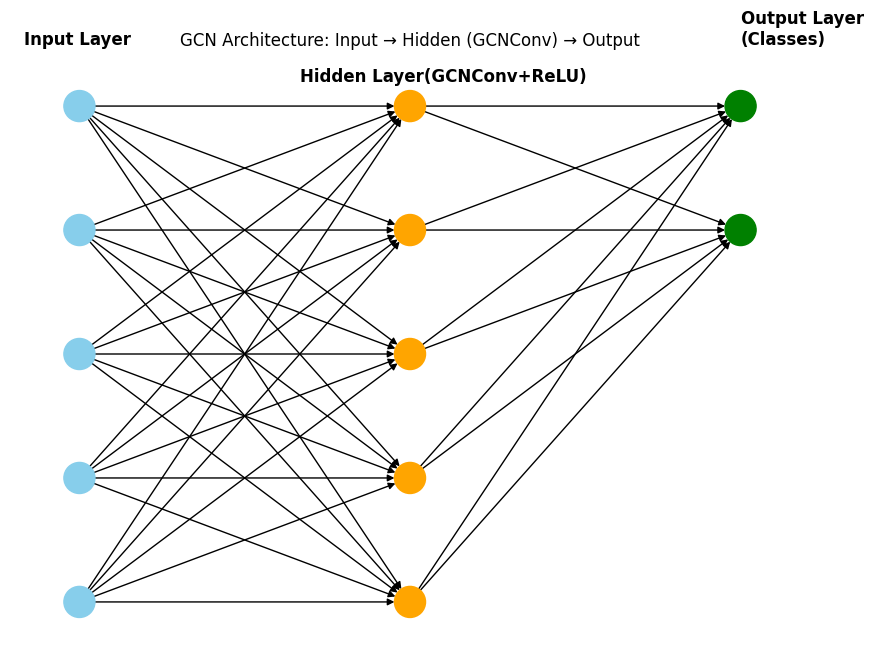

In [101]:
import matplotlib.pyplot as plt
import networkx as nx

# สร้างโครงสร้าง GCN: Input Layer → Hidden Layer → Output Layer
G = nx.DiGraph()

layers = {
    "Input (Node Features)": range(5),      # ตัวอย่างมี 5 nodes input
    "Hidden (GCNConv + ReLU)": range(5, 10),
    "Output (Node Classes)": range(10, 12)  # 2 classes: Real/Fake
}

# เพิ่ม node
for layer, nodes in layers.items():
    for node in nodes:
        G.add_node(node, layer=layer)

# เชื่อม edge แบบ fully-connected ระหว่างแต่ละชั้น
for i in layers["Input (Node Features)"]:
    for j in layers["Hidden (GCNConv + ReLU)"]:
        G.add_edge(i, j)
for i in layers["Hidden (GCNConv + ReLU)"]:
    for j in layers["Output (Node Classes)"]:
        G.add_edge(i, j)

# จัดตำแหน่ง node แยกเป็น layers
pos = {}
x_gap = 3
for i, (layer, nodes) in enumerate(layers.items()):
    for j, node in enumerate(nodes):
        pos[node] = (i * x_gap, -j)

# map สี
color_map = []
for node in G.nodes():
    if node < 5:
        color_map.append("skyblue")  # input
    elif node < 10:
        color_map.append("orange")   # hidden
    else:
        color_map.append("green")    # output

# วาดกราฟ
plt.figure(figsize=(8,6))
nx.draw(G, pos, with_labels=False, node_color=color_map, node_size=500, arrows=True)

# เพิ่ม label ชื่อ layer (ใช้ตำแหน่งเฉพาะ)
plt.text(-0.5, 0.5, "Input Layer", fontsize=12, fontweight="bold")
plt.text(2, 0.2, "Hidden Layer(GCNConv+ReLU)", fontsize=12, fontweight="bold")
plt.text(6, 0.5, "Output Layer\n(Classes)", fontsize=12, fontweight="bold")

plt.title("GCN Architecture: Input → Hidden (GCNConv) → Output")
plt.axis("off")
plt.show()

